In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import joypy
import requests
import json

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


import tracemalloc
import time
import yellowbrick
from yellowbrick.regressor import ResidualsPlot, CooksDistance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot

import lime 
from lime import lime_tabular
import shap
shap.initjs()
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df_HDB.csv')
y = df[['resale_price']]
X = df.drop(['resale_price','town', 'year'], axis=1)

In [3]:
def tracing_start():
    tracemalloc.stop()
    print("nTracing Status : ", tracemalloc.is_tracing())
    tracemalloc.start()
    print("Tracing Status : ", tracemalloc.is_tracing())
def tracing_mem():
    first_size, first_peak = tracemalloc.get_traced_memory()
    peak = first_peak/(1024*1024)
    print("Peak Size in MB - ", peak)

In [4]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, shuffle=True, random_state=0)

xgbr_grid_model = xgb.XGBRegressor( 
    # Warning! Parameters: { "silent" } might not be used, hence removed
    colsample_bytree = 0.7,
    n_estimators= 500,
    nthread= 4,
    min_child_weight= 4,
    learning_rate= 0.07,
    max_depth= 7,
    objective = 'reg:squarederror',
    subsample = 0.7
)

tracing_start()
start = time.time()

#Fitting model and train data
xgbr_grid_model.fit(X_train, y_train)

xgbr_grid_model_score = xgbr_grid_model.score(X_train, y_train)   
print("Training data score: ", xgbr_grid_model_score) 
 
# cross validation 
xgbr_grid_model_cv_scores = cross_val_score(xgbr_grid_model, X_train, y_train, cv=5)
print("Mean cross-validation score: %.4f" % xgbr_grid_model_cv_scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_xgbr_grid_model_cv_scores = cross_val_score(xgbr_grid_model, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.4f" % kf_xgbr_grid_model_cv_scores.mean())
end = time.time()
tracing_mem()

tracing_start()
start = time.time()
# Getting ypred (or prediction) values on X_test set
xgbr_grid_model_predicted_test = xgbr_grid_model.predict(X_test)

# Getting score on test set and calculate mean absolute error, mean squared error and root mean-squared error
xgbr_grid_model_test_score = r2_score(y_test, xgbr_grid_model_predicted_test)
xgbr_grid_model_mse = mean_squared_error(y_test, xgbr_grid_model_predicted_test)
xgbr_grid_model_mae = mean_absolute_error(y_test, xgbr_grid_model_predicted_test)
print("Test data R\u00b2 score: %.4f" % (xgbr_grid_model_test_score))
print("Test data Root Mean Squared Error: %.4f" % xgbr_grid_model_mse)
print("Test data Mean Absolute Error: %.4f" % xgbr_grid_model_mae)
print("Test data Root Mean Squared Absolute Error: %.4f" % (xgbr_grid_model_mse**(1/2.0)))
end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

nTracing Status :  False
Tracing Status :  True
Training data score:  0.9721992860859993
Mean cross-validation score: 0.9656
K-fold CV average score: 0.9659
Peak Size in MB -  56.69856262207031
nTracing Status :  False
Tracing Status :  True
Test data R² score: 0.9676
Test data Root Mean Squared Error: 716424176.6223
Test data Mean Absolute Error: 20101.8855
Test data Root Mean Squared Absolute Error: 26766.1013
time elapsed 46.869754791259766 milli seconds
Peak Size in MB -  2.666733741760254


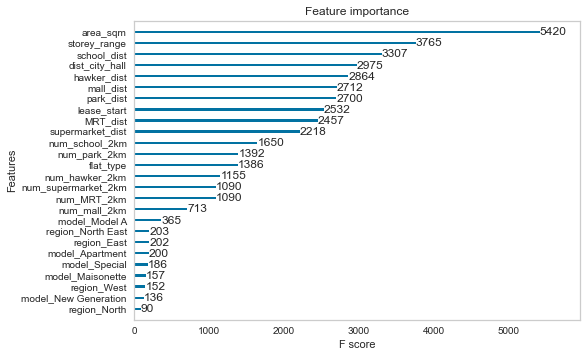

In [5]:
# Plot feature importance
xgb.plot_importance(xgbr_grid_model)
plt.rcParams['figure.figsize'] = [10,7]
plt.grid(False)
plt.show()